# 7. Active contours

Sometimes, a segmentation is imperfect, e.g. the circular objects in the last chapter are broken. As binary operations are local (within a region) it is impossible to incorporate global information (my object should be a circle) in those algorithms.

One useful class of algorithms that do include a global information are adaptive contours. Those are chains (usually closed) of points forming a contour that attempts to deform to match some image feature. Deformation occurs under two constrains: 1. maximize some function based on the image intensity (e.g. try to reach bright regions) and 2. minimize some deformation energy to keep a "smooth" shape.

skimage implements a version of the active contour algorithm that we are going to explore here._

In [2]:
from skimage.segmentation import active_contour

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.external.tifffile import TiffFile
from skimage.measure import label, regionprops

import course_functions
datapath = course_functions.define_data_path()

#import your function
from course_functions import detect_nuclei

/Users/gw18g940/miniconda3/envs/teaching_test/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 14 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


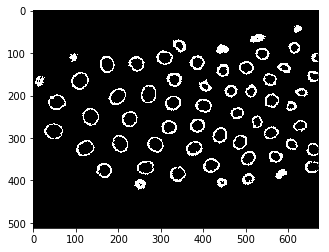

In [5]:
#load the image to process
data = TiffFile(datapath+'Data/30567/30567_orig.tiff')
image = data.pages[3].asarray()
#create your mask
nuclei = detect_nuclei(image)
plt.imshow(nuclei, cmap = 'gray')
plt.show()

## 7.1 Overlaying information on an image

We are going to plot vectorial information (series of points) on top of our image. We begin here by showing how to do that. Let's gather some information on your segmented image:

In [6]:
image_label = label(nuclei)
nuclei_props = regionprops(image_label)

We have the coordinates of the center of mass of each nucleus:

In [7]:
nuclei_props[20].centroid

(178.63744075829385, 404.4265402843602)

So let's try to plot a dot for each nucleus on the image:

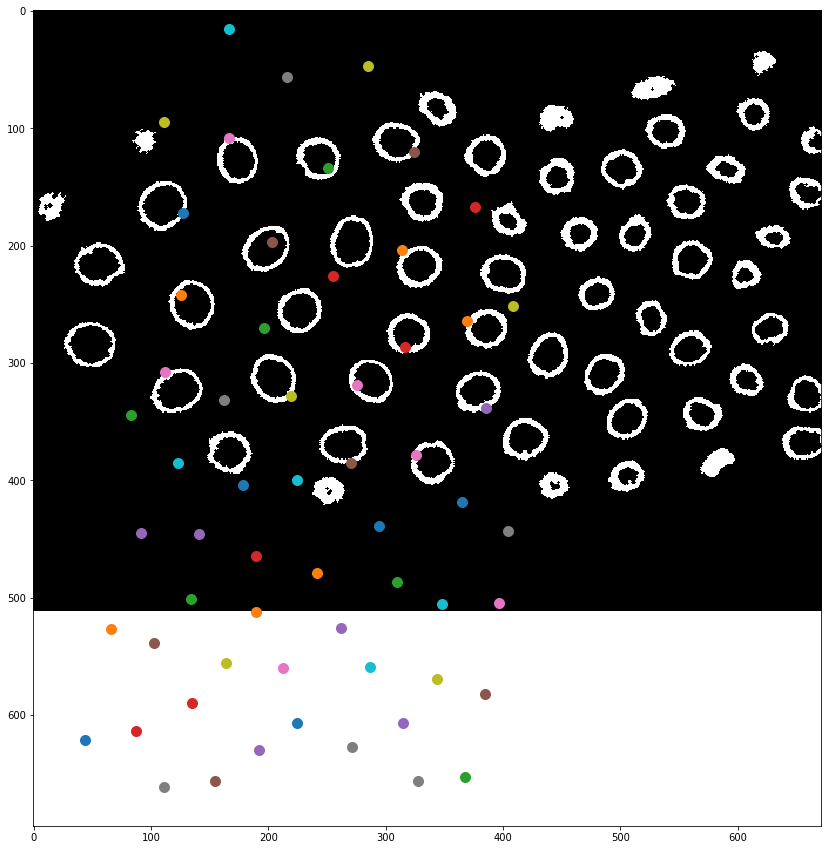

In [8]:
plt.figure(figsize=(15,15))
plt.imshow(nuclei, cmap = 'gray')
for x in nuclei_props:
    plt.plot(x.centroid[0],x.centroid[1],'o',markersize = 10)
plt.show()

Something clearly went wrong. Images have a specific coordinate system. The first dimension is rows from top to bottom, and the second dimension is columns from left to right. so we have to inverse the coordinates of our centroids which are given in classical xy style:

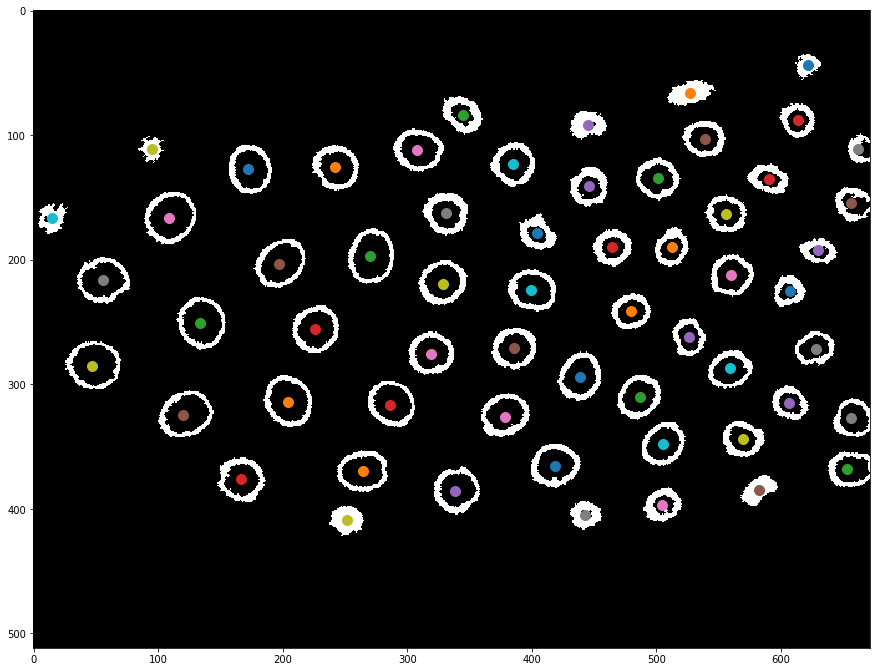

In [9]:
plt.figure(figsize=(15,15))
plt.imshow(nuclei, cmap = 'gray')
for x in nuclei_props:
    plt.plot(x.centroid[1],x.centroid[0],'o',markersize = 10)
plt.show()

To make test, we might want to select a specific nucleus. For that it is hepful to know which is one. We can simply write the region index on the image:

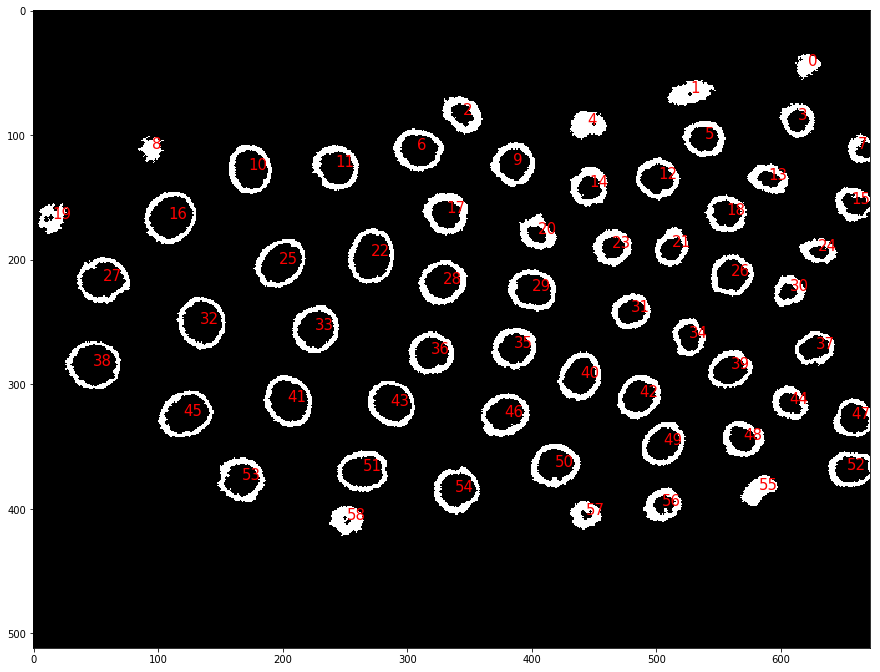

In [10]:
plt.figure(figsize=(15,15))
plt.imshow(nuclei, cmap = 'gray')
for ind, x in enumerate(nuclei_props):
    plt.text(s = str(ind), x = x.centroid[1], y = x.centroid[0],color = 'Red',size = 15)
plt.show()

## 7.2 Setting-up the active contour

We are going to usa nucleus #33 as a test case. We are going to need two things: an image, and an starting configuration for the contour.

We can extract the necessary image using the bounding box information. We consider a box slightly larger than the one of the segmentation to avoid cutting off information:

In [11]:
reg33 = nuclei_props[33]
print(reg33.bbox)

(237, 208, 275, 246)


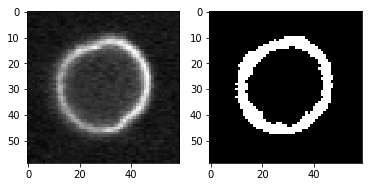

In [12]:
subimage = image[237-10:275+11,208-10:246+11]
submask = nuclei[237-10:275+11,208-10:246+11]
plt.subplot(1,2,1)
plt.imshow(subimage,cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(submask,cmap = 'gray')
plt.show()

For the contour, we can either start with a simple geometric shape and place it in the center of the image, or we can try to extract a shape closer to our needs using the segmentation.

For example we can extract the mask contour using the skimage function find_contour(). We need to provide an image as well as the intensity at which to define the contour:

In [13]:
from skimage.measure import find_contours

In [14]:
contours = find_contours(submask,level = 0.5)
print(len(contours))

2


The function returned to paths. Let's verify what they are:

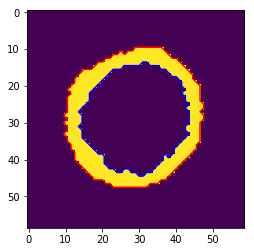

In [15]:
plt.imshow(submask)
#first contour in red
plt.plot(contours[0][:,1],contours[0][:,0],'r')
#second contour in blue
plt.plot(contours[1][:,1],contours[1][:,0],'b')
plt.show()

One is the inner (blue), the other the outer (red) contour. We will keep the inner contour to be sure that the active contour will not explore the region outside of the nucleus towards other nuclei.

In [16]:
init_contour = contours[1]

## 7.3 Running the active contour

Now we have all we need to run the active contour algorithm. The parameters alpha and beta control the deformability of the contour (contration and bending). The w_line and w_edge paramters control whether the active contour is driven towards bright regions or towards regions with sharp boundaries.

In our case, we want to contour to seek bright region (w_line = 1). Picking values for alpha and beta occurs mainly by trial and error.

In [17]:
final_contour = active_contour(image = subimage, snake = init_contour, alpha=0.2, beta=20, w_line=1, w_edge=0)

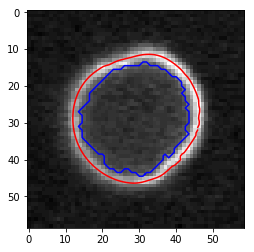

In [18]:
plt.imshow(subimage, cmap = 'gray')
plt.plot(init_contour[:,1],init_contour[:,0],'b')
plt.plot(final_contour[:,0],final_contour[:,1],'r')
plt.show()

The result is excellent but of course we started close to the good solution. Let's take a more extreme case:

In [19]:
init_circle = np.array([[30+12*np.cos(2*np.pi*x/100), 30+12*np.sin(2*np.pi*x/100)] for x in range(100)])

It ususally helps to slightly smooth the image, to avoid a contour with too many kinks.

In [20]:
from skimage.filters import gaussian
imgauss = gaussian(subimage.astype(float),1)

In [21]:
final_contour = active_contour(image = imgauss, snake = init_circle, alpha=0.3, beta=30, 
                               w_line=0.0001, w_edge=0, max_iterations=3000,)

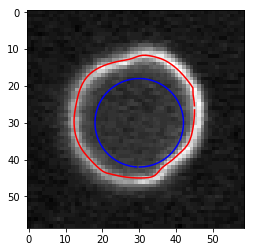

In [22]:
plt.imshow(subimage, cmap = 'gray')
plt.plot(init_circle[:,1],init_circle[:,0],'b')
plt.plot(final_contour[:,0],final_contour[:,1],'r')
plt.show()